In [2]:
### File Originally Created By Bipul Pandey on 9th Feb 2024

### Python Version - 3.9.12
### Scipy Version - 1.7.3
### Matplotlib Version -  3.5.1 
### Scikit-learn Version - 1.0.2
### numpy Version -  1.21.6 
### Pandas Version - 1.4.2

## This notebook contains the following:
    #   1) RF Model Construction on Original 81 communities' Metabolite Log-2-fold change
    #   2) Validation of this model
    #   3) Performance on 60 Out-of-sample Experiments

## The relevant dataset is the raw dataset containing measurements of Metabolite Z scores at 120 hours and KP CFU

## Name of the Dataset : "Metabolite_120_Hr_dataset.csv"


In [5]:
### Packages Necessary
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import pandas as pd


from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score


___
### A. Reading the Dataset and Partitioning it into relevant data and labels

- We first read the file containing the metabolite change as well as the KP loads at the end of 120 hours. This data is in the file with the following name   - $\text{Metabolite\_120\_Hr\_dataset.csv}$.

- This file can be found in the "$\text{Datasets}$" folder.

- We then create separate arrays containing the respective community names, metabolite names, KP loads as well as the metabolite concentration matrix. 

_____


In [6]:
Metabolite_file = "../Datasets/Metabolite_120_Hr_dataset.csv"

Metabolite_dataset = pd.read_csv(Metabolite_file)

### Separating the dataframe into relevant data ana labels
Community = np.array(Metabolite_dataset.columns[0])
Metabolite_names = np.array(Metabolite_dataset.columns[1:-1])
KP_CFU = np.array(Metabolite_dataset[Metabolite_dataset.columns[-1]])
Metabolite_matrix = np.array(Metabolite_dataset[Metabolite_names])


___
___
### B. Regularization and Normalization of the Dataset:
1. $\underline{\text{Regularization}}$:
- We only care about order of magnitude of KP CFU. Hence we will take a $\text{Log}_{10}$ of the data. 
- Before that we need to regularize the KP CFU by adding a small regularizer.
- Regularizer could be 1 or 10. It is just so that logarithm doesn't give -infinity in communities where KP CFU was below measurement threshold.

2. $\underline{\text{Normalization of Datamatrix}}$:
- We will also need to center and normalize the metabolite matrix - i.e subtract the mean and divide by the variance for each metabolite panel.
- We will visualize the raw and the normalized datamatrix to see the difference between the two.
___

In [7]:
### we only care about order of magnitude of KP CFU. Hence we will take a log. 
### Before that we need to regularize the KP CFU by adding a small regularizer
# Regularizer could be 1 or 10. It is just so that logarithm doesn't give -infinity in communities where KP CFU was below measurement threshold.
regularizer = 10    
Log_KP_CFU = np.log10(KP_CFU+regularizer)


### We will also need to center and normalize the metabolite matrix - i.e subtract the mean and divide by the variance for each metabolite panel.
Normalized_metabolite_matrix = StandardScaler().fit_transform(Metabolite_matrix)

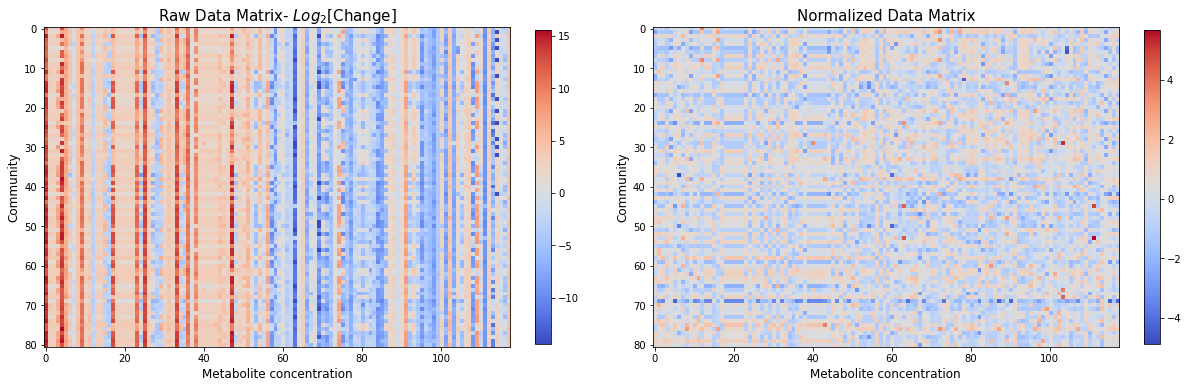

In [8]:
### Visualization of Raw data matrix and the normalized data matrix
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (20,10))
im0= ax[0].imshow(Metabolite_matrix, cmap = "coolwarm")
fig.colorbar(im0, ax=ax[0], fraction = 0.031)
ax[0].set_xlabel("Metabolite concentration", fontsize = 12)
ax[0].set_ylabel("Community", fontsize = 12)
ax[0].set_title(r"Raw Data Matrix- $Log_{2}$[Change]", fontsize = 15)


im1= ax[1].imshow(Normalized_metabolite_matrix, cmap = "coolwarm")
fig.colorbar(im1, ax= ax[1],fraction = 0.031)
ax[1].set_xlabel("Metabolite concentration", fontsize = 12)
ax[1].set_ylabel("Community", fontsize = 12)
ax[1].set_title("Normalized Data Matrix", fontsize = 15)
plt.show()

___________
___________
### C. Splitting the Dataset into Train and Test Sets:

##### C.1 $\underline{\text{Construction of the base Train and Test Sets.}}$
$\text{Random Forest(RF) Models}$ heavily depend on the endpoints of the datasets. 
If the model does not know the full range of data it needs to predict on, it flatlines for test set data that lies outside the train set's range. Hence, we need to make sure training and test set data ranges are same. In order to achieve this, we implement the following strategy:

1. First, sort the KP CFU (or log10 KP CFU) for the whole dataset. 
2. Select alternate datapoints in this sorted dataset as training and test set members.
3. Make sure that the community with smallest and largest KP CFU are in train set (Train Set Range >= Test Set Range)
4. Depending on what train/test split you want (60/40 or 70/30 percent), move random communities from Test to Train set.


We will first implement steps 1,2 and 3 under section C.1 to construct a rough 50-50 train-test split.
We will tune the train/test split in section C.2.
___

In [16]:
### Split the dataset into train and test sets:
### Random Forest models heavily depends on the endpoints. 

Sorted_argument = np.argsort(Log_KP_CFU)
Train_index = []
Test_index = []
for i, elem in enumerate(Sorted_argument):
    if np.mod(i,2) ==0 or i ==Sorted_argument[-1]:
        Train_index.append(elem)
    else:
        Test_index.append(elem)


## Train and Test Sets:
Train_set = Metabolite_dataset.iloc[Train_index]
Test_set = Metabolite_dataset.iloc[Test_index]

Train_set_log_CFU= Log_KP_CFU[Train_index]
Test_set_log_CFU = Log_KP_CFU[Test_index]

## The normalized Training and Test Set Datamatrix:
Train_set_array = StandardScaler().fit_transform(np.array(Train_set[Metabolite_names]))
Test_set_array = StandardScaler().fit_transform(np.array(Test_set[Metabolite_names]))

## 
Train_index = np.array(Train_index)
Test_index = np.array(Test_index)

print("Lengths of Training and Test Sets =",len(Train_index), "and",len(Test_index))

Lengths of Training and Test Sets = 41 and 40


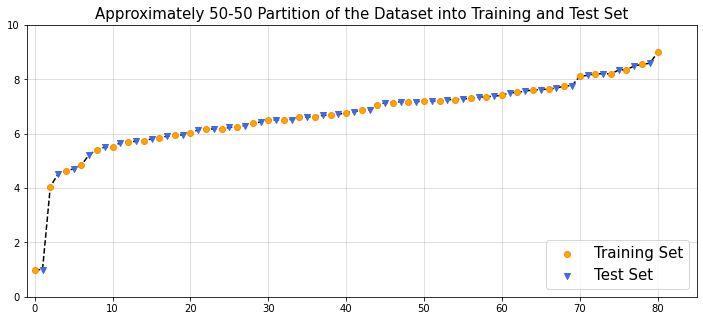

In [17]:
plt.figure(figsize=(12,5))
plt.title("Approximately 50-50 Partition of the Dataset into Training and Test Set", fontsize = 15)
plt.plot(Log_KP_CFU[Sorted_argument], "--", color = "black")
plt.scatter(range(0,81,2), Train_set_log_CFU, color = "orange", edgecolor = "darkorange", marker = "o", zorder = 2, label = "Training Set")
plt.scatter(range(1,81,2), Test_set_log_CFU, color = "royalblue", marker = "v", zorder = 2, label = "Test Set")
plt.grid(alpha = 0.3, zorder = 0, color = "gray")
plt.ylim(0,10)
plt.xlim(-1,85)
plt.legend(labelcolor = "black", loc = "lower right", fontsize =15)
plt.show()

### C.2 Changing the Train-Test partition:

We may not want the 50-50 partition between the train and test set. In that case, we randomly choose points from one set and mode to the other depending on the percentage of data we want to maintain between the two sets.

In [18]:
print("Old Lengths of Training and Test Sets =",len(Train_index), "and",len(Test_index))
### If we want a difference split between training and Test set:
### This is the only number we need to change here

Train_set_percent = 60                       #<== Tune this parameter.





##################################
Test_set_percent = (100-Train_set_percent)

## I need to remove some points from the test set.
Num_pts_to_remove_from_test_set = int(len(Test_index) - (len(Log_KP_CFU))* Test_set_percent/100)
Num_pts_to_remove_from_test_set = np.min((Num_pts_to_remove_from_test_set, len(Test_index)))

if Num_pts_to_remove_from_test_set>=0:
    set_name = "Test Set"
    From_set = Test_index
    Idx_to_remove = np.random.choice(range(0,len(From_set)), Num_pts_to_remove_from_test_set,replace=False)
    Set_to_remove = From_set[Idx_to_remove]
    Test_index=np.delete(Test_index, Idx_to_remove)
    Train_index= np.concatenate((Train_index, Set_to_remove))

else:
    set_name = "Train Set"
    From_set = Train_index
    To_set = Test_index
    Idx_to_remove = np.random.choice(range(0,len(From_set)), Num_pts_to_remove_from_test_set,replace=False)
    Set_to_remove = From_set[Idx_to_remove]
    np.delete(Train_index, Idx_to_remove)
    Train_index= np.concatenate((Test_index, Set_to_remove))


#################
print("---------")
print("We need to remove",Num_pts_to_remove_from_test_set, "Points from "+ set_name)
print("---------")
#################

## New Train and Test Sets with these edits:
Train_set = Metabolite_dataset.iloc[Train_index]
Test_set = Metabolite_dataset.iloc[Test_index]

Train_set_log_CFU= Log_KP_CFU[Train_index]
Test_set_log_CFU = Log_KP_CFU[Test_index]

## The normalized Training and Test Set Datamatrix:
Train_set_array = StandardScaler().fit_transform(np.array(Train_set[Metabolite_names]))
Test_set_array = StandardScaler().fit_transform(np.array(Test_set[Metabolite_names]))

## 
Train_index = np.array(Train_index)
Test_index = np.array(Test_index)

print("New Lengths of Training and Test Sets =",len(Train_index), "and",len(Test_index))



Old Lengths of Training and Test Sets = 41 and 40
---------
We need to remove 7 Points from Test Set
---------
New Lengths of Training and Test Sets = 48 and 33


____
____
### D. Random Forest Regression Model Construction:

##### $\underline{\text{Parameters of RF Model}}$:
    1. N-estimators = The total number of decision trees we have in this model.
    2. Criteria = The error function all trees minimize to make their decision.
    3. Bootstrap = "True"  - Does each tree create a dataset of size equivalent to original dataset through bootstrap? 
    4. Max_features = The number of features each tree takes into account to make its decision. ('sqrt'-> square-root of total  features of the data). 
    5. Min_split = The extent of split. Here 2 mean we split until we hit a pure node. 



_____
    

In [23]:

#### Now we are set to construct out Random Forest:
N_estimators = 10000               ##This is the number of trees. Increase or decrease this to how many ever trees you want. The more trees- the slower the training.
Criteria = 'squared_error'      #“squared_error”, “absolute_error”, “friedman_mse”, “poisson”
Bootstrap = True

#Max_features = 'log2'
Max_features = 'sqrt'
Min_split = 2

Random_Forest = RandomForestRegressor(n_estimators=N_estimators, bootstrap=Bootstrap,criterion=Criteria, min_samples_split=Min_split, max_features=Max_features)

RF_regressor = Random_Forest.fit(Train_set_array, Train_set_log_CFU)

In [32]:
#Predictions on Training and Test set:

Prediction_on_train_set = RF_regressor.predict(Train_set_array)
Prediction_on_test_set = RF_regressor.predict(Test_set_array)

### R^2 values to measure performance:
r2_score_train = r2_score(y_true= Train_set_log_CFU, y_pred =Prediction_on_train_set)
r2_score_test = r2_score(y_true= Test_set_log_CFU, y_pred =Prediction_on_test_set)


print("R^2 value on Train Set =", r2_score_train)
print("R^2 value on Test Set=", r2_score_test)

if np.sign(r2_score_test)==-1:
    print("----A Negative R^2 can often occur----")
    print("This means that our RF model is worst than just predicting the mean Log_10 KP_CFU.")

R^2 value on Train Set = 0.8947029169470947
R^2 value on Test Set= -0.1127424445675358
----A Negative R^2 can often occur----
This means that our RF model is worst than just predicting the mean Log_10 KP_CFU.


##### $\underline{\text{Plotting the RF model predictions on training and test sets:}}$

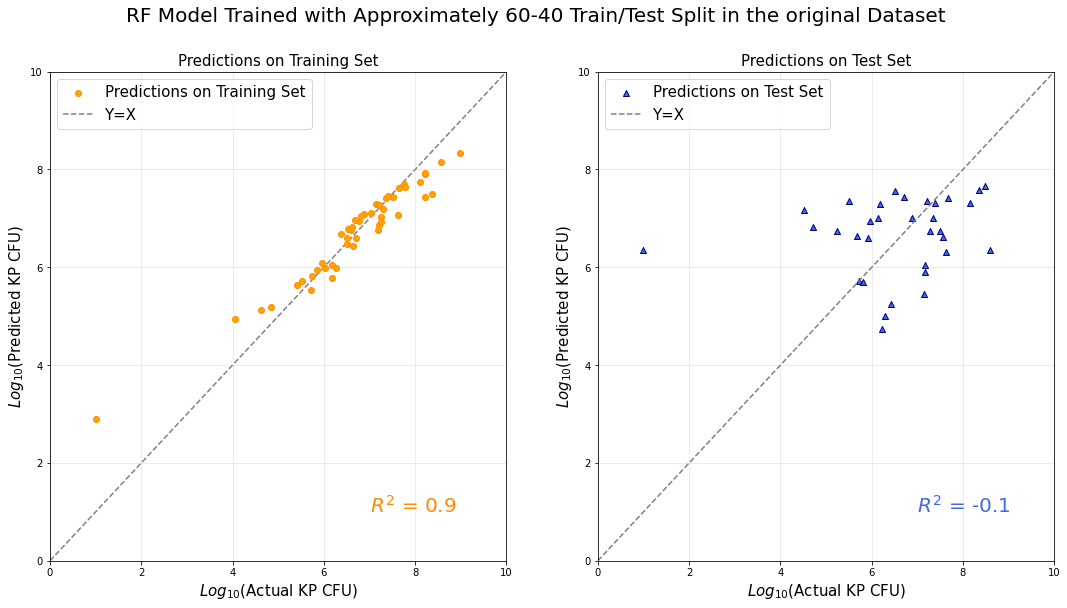

In [35]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(18,9))
ax[0].scatter(Train_set_log_CFU, Prediction_on_train_set, marker="o",color = "orange",edgecolor = "darkorange", label = "Predictions on Training Set", zorder = 2)
ax[0].plot(range(0,11),range(0,11), "--", label = "Y=X", zorder = 1, color = "gray")
ax[0].grid(alpha = 0.3, zorder = 0)
ax[0].text(s=r"$R^2$ = %.1f"%(r2_score_train), x= 7, y = 1, fontsize = 20, color = "darkorange")

ax[0].set_xlabel(r"$Log_{10}$(Actual KP CFU)", fontsize = 15)
ax[0].set_ylabel(r"$Log_{10}$(Predicted KP CFU)", fontsize = 15)

ax[1].scatter(Test_set_log_CFU, Prediction_on_test_set, marker ="^",color = "royalblue",edgecolor = "darkblue",label = "Predictions on Test Set", zorder = 2)
ax[1].plot(range(0,11), range(0,11), "--",label = "Y=X",color = "gray")

ax[1].set_xlabel(r"$Log_{10}$(Actual KP CFU)", fontsize = 15)
ax[1].set_ylabel(r"$Log_{10}$(Predicted KP CFU)", fontsize = 15)
ax[1].grid(alpha = 0.3, zorder = 0)
ax[1].text(s=r"$R^2$ = %.1f"%(r2_score_test), x= 7, y = 1, fontsize = 20, color = "royalblue")

ax[0].set_xlim(0,10)
ax[0].set_ylim(0,10)

ax[1].set_xlim(0,10)
ax[1].set_ylim(0,10)

ax[0].set_title("Predictions on Training Set", color = "black", fontsize = 15)
ax[1].set_title("Predictions on Test Set", color = "black", fontsize = 15)
fig.suptitle("RF Model Trained with Approximately " +str(Train_set_percent)+"-"+str(Test_set_percent) + " Train/Test Split in the original Dataset", fontsize = 20)
ax[1].legend(fontsize = 15)
ax[0].legend(fontsize = 15)
plt.show()

___
___
### E. Random Forest Model's Performance on Out-of-Sample (OOS) experiments

Although RF model's performance in Training Set is good ($R^2$ =0.9), we can already see that the performance of RF model on the test set is abysmal. On unknown (or community not in train set) community, a prediction of average $\text{Log}_{10}$[ KP CFU] would be a better measure ($R^2$ = 0) than this RF model.

We expect a poor performance of this RF model on the 60 out of sample experiments as well. 

- We first upload the OOS dataset
- Then we separate it into relevant data and the labels
- Then we normalize and center the Datamatrix.
- Then we use the RF model trained above to predict the $Log_{10}$ [KP CFU]
- We measure the performace using $R^2$ metric.
___

In [36]:
### Reading OOS Dataset
OOS_Datafile_name = "../Datasets/Metabolite_120_Hrs_OOS_set_log10_CFU.csv"
OOS_Dataframe = pd.read_csv(OOS_Datafile_name)

### Separating the dataframe into relevant data ana labels
OOS_Community = np.array(OOS_Dataframe["Community"])

OOS_Log_10_CFU = np.array(OOS_Dataframe["Log10_KP_CFU"])
OOS_metabolite_Datamatrix = np.array(OOS_Dataframe[Metabolite_names])

### Normalizing and centering the datamatrix
Normalized_OOS_metabolite_Datamatrix = StandardScaler().fit_transform(OOS_metabolite_Datamatrix)



In [37]:
### Prediction and Performance measurement

Prediction_on_OOS_set = RF_regressor.predict(Normalized_OOS_metabolite_Datamatrix)


r2_score_OOS = r2_score(y_true = OOS_Log_10_CFU, y_pred = Prediction_on_OOS_set)

print("R^2 on OOS Set = %.2f" %r2_score_OOS)
if np.sign(r2_score_OOS)== -1:
    print("----A Negative R^2 can often occur----")
    print("This means that our RF model is worst than just predicting the mean Log_10 KP_CFU.")


R^2 on OOS Set = -0.04
----A Negative R^2 can often occur----
This means that our RF model is worst than just predicting the mean Log_10 KP_CFU.


##### $\underline{\text{Plotting the RF Model Predictions on out-of-sample communities:}}$

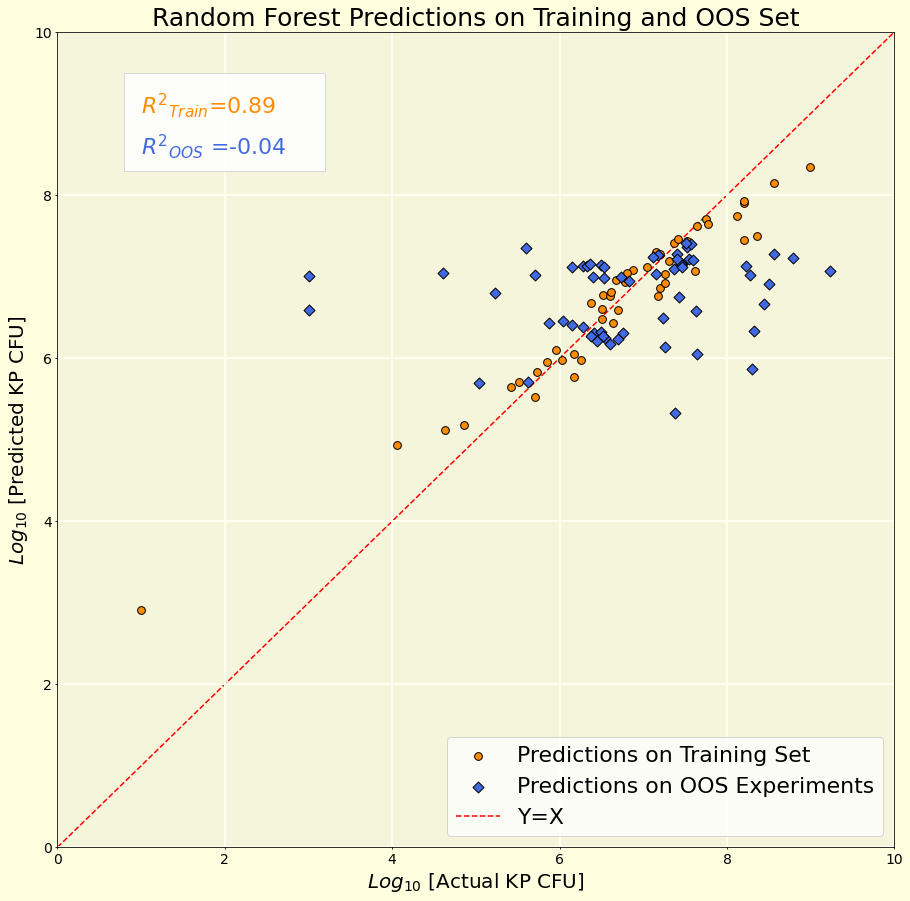

In [38]:
###   Visualizing the Performace


fig, ax = plt.subplots(1,figsize=(15,15))
plt.scatter(Train_set_log_CFU, Prediction_on_train_set,s=60, marker ="o", color = "darkorange",edgecolors = "black",label = "Predictions on Training Set", zorder = 2)
plt.scatter(OOS_Log_10_CFU, Prediction_on_OOS_set, s= 60,color = "royalblue", label = "Predictions on OOS Experiments", marker = "D", zorder = 3, edgecolors="black")
plt.plot(range(0,11), range(0,11), label = "Y=X", color = "red", zorder = 1, linestyle = "dashed")

ax.set_xlabel(r"$Log_{10}$ [Actual KP CFU]", fontsize = 20, color = "black")
ax.set_ylabel(r"$Log_{10}$ [Predicted KP CFU]", fontsize = 20, color = "black")

ax.set_title("Random Forest Predictions on Training and OOS Set", color = "black", fontsize = 25)
ax.text(x = 1, y = 9, s = r"${R^2}_{Train}$=" +'%.2f'%(r2_score_train), color = "darkorange", fontsize = 22)
ax.text(x = 1, y = 8.5, s = r"${R^2}_{OOS}$ ="+'%.2f'%(r2_score_OOS), color = "royalblue", fontsize = 22)


####adding a rectangle
rect = patches.Rectangle((0.8,8.3),2.4,1.2,linewidth = 1, zorder = 2, color = "white", alpha = 0.9)
rect1 = patches.Rectangle((0.8,8.3),2.4,1.2,linewidth = 1, zorder = 2, color = "lightgray",fill=False, alpha = 0.9)
ax.add_patch(rect)
ax.add_patch(rect1)
ax.legend(labelcolor = "black", loc = "lower right", frameon = True, fancybox = True, facecolor = "white", fontsize = 22)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.tick_params(size = 2)
ax.grid( linestyle = "solid", color = "ivory", zorder = 1, linewidth = 2)
fig.set_facecolor("lightyellow")
ax.set_facecolor("beige")
ax.tick_params(axis='both', labelsize = 14)
plt.show()

______
### End of Notebook:
_____
_____